# 타이타닉 데이터를 통한 분류 (Classification) 실습
### 0) Titanic Dataset Preprocessing (타이타닉 데이터셋 전처리)
### 1) Decision Tree (의사결정 나무)
### 2) Random Forest (랜덤 포레스트)
### 3) Naive Bayes (나이브 베이즈)
### 4) Decision Tree vs. Random Forest vs. Naive Bayes Classifier
### 5) ROC Curves
### 6) K-NN (K-Nearest Neighbors, K 최근접 이웃)

# 0) Titanic Dataset Preprocessing
### 데이터 구조 확인

In [1]:
install.packages("VIM")

library(dplyr)
library(VIM)
library(mice)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘nloptr’, ‘pbkrtest’, ‘lme4’, ‘car’, ‘laeken’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind




In [2]:
# import와 동시에 결측값 처리 ("", " ", "NA"를 모두 결측치로 인식)
train <- read.csv("/kaggle/input/titanic/train.csv", na.strings=c("", " ", "NA"))
test <- read.csv("/kaggle/input/titanic/test.csv", na.strings=c("", " ", "NA"))

print("Train Dataset")
head(train)

print("Test Dataset")
head(test)

[1] "Train Dataset"


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


[1] "Test Dataset"


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NA,Q
2,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NA,S
3,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NA,Q
4,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NA,S
5,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NA,S
6,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NA,S


### 데이터타입 변환
* **Factorization**이 필요한 변수: PassengerId, Survived, Pclass, Sex, Embarked

In [3]:
train <- train %>% mutate(PassengerId = as.factor(PassengerId),
                          Survived = as.factor(Survived),
                          Pclass = as.factor(Pclass),
                          Sex = as.factor(Sex),
                          Embarked = as.factor(Embarked))

In [4]:
str(train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: Factor w/ 891 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  NA "C85" NA "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


In [5]:
nrow(train)

[1] 891

### 결측값 처리
* **VIM Library**: 데이터프레임 내 변수별 Missing Values(결측치)를 그래프화해주는 라이브러리
* **mice Library**: 결측치 처리 라이브러리

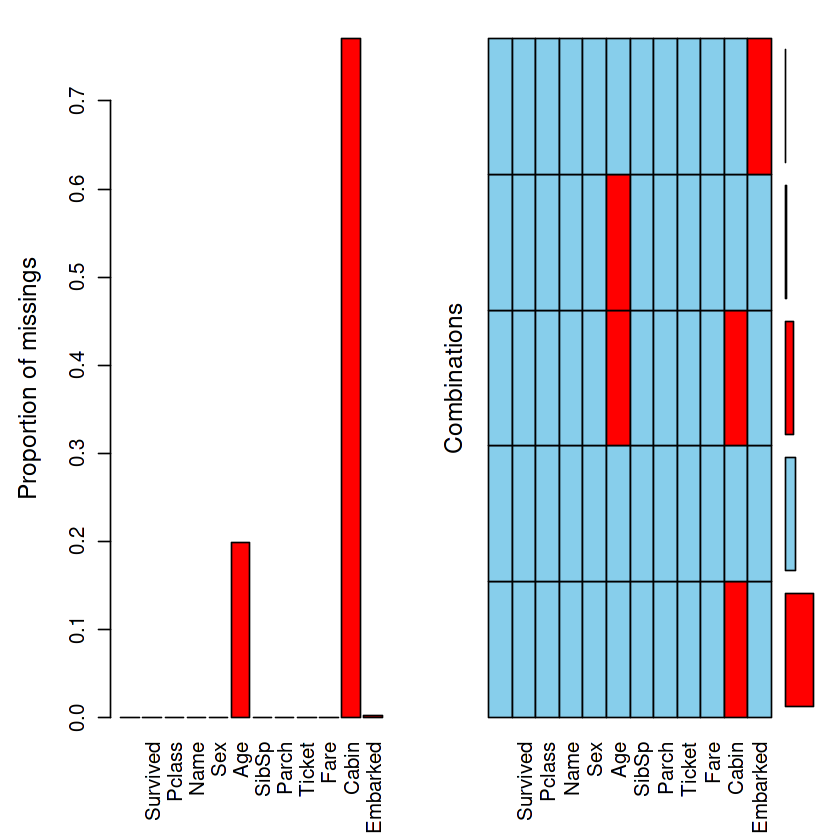

In [6]:
aggr(train) # train dataset의 결측치 시각화

# Cabin column은 결측치가 전체 데이터 중 70% 이상, 모델에서 배제
# Age에 존재하는 20%의 결측치는 Imputation (결측값 대체)을 통해 처리

In [7]:
train_new <- train %>% select(Survived, Pclass, Sex, Age, 
                              SibSp, Parch, Fare, Embarked)
head(train_new)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>
1,0,3,male,22,1,0,7.2500,S
2,1,1,female,38,1,0,71.2833,C
3,1,3,female,26,0,0,7.9250,S
4,1,1,female,35,1,0,53.1000,S
5,0,3,male,35,0,0,8.0500,S
6,0,3,male,NA,0,0,8.4583,Q


In [8]:
# Age 칼럼에서 결측치가 아닌 값들을 'rf (랜덤 포레스트)' 방식으로 선정해 결측치를 대체
train_imputed <- mice(train_new, method='rf', seed=1234)
summary(train_imputed)


 iter imp variable
  1   1  Age  Embarked
  1   2  Age  Embarked
  1   3  Age  Embarked
  1   4  Age  Embarked
  1   5  Age  Embarked
  2   1  Age  Embarked
  2   2  Age  Embarked
  2   3  Age  Embarked
  2   4  Age  Embarked
  2   5  Age  Embarked
  3   1  Age  Embarked
  3   2  Age  Embarked
  3   3  Age  Embarked
  3   4  Age  Embarked
  3   5  Age  Embarked
  4   1  Age  Embarked
  4   2  Age  Embarked
  4   3  Age  Embarked
  4   4  Age  Embarked
  4   5  Age  Embarked
  5   1  Age  Embarked
  5   2  Age  Embarked
  5   3  Age  Embarked
  5   4  Age  Embarked
  5   5  Age  Embarked
Class: mids
Number of multiple imputations:  5 
Imputation methods:
Survived   Pclass      Sex      Age    SibSp    Parch     Fare Embarked 
      ""       ""       ""     "rf"       ""       ""       ""     "rf" 
PredictorMatrix:
         Survived Pclass Sex Age SibSp Parch Fare Embarked
Survived        0      1   1   1     1     1    1        1
Pclass          1      0   1   1     1     1    1       

In [9]:
# complete()를 활용해 train 데이터 imputation
train_final <- complete(train_imputed, 1)
head(train_final)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
,<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>
1,0,3,male,22,1,0,7.2500,S
2,1,1,female,38,1,0,71.2833,C
3,1,3,female,26,0,0,7.9250,S
4,1,1,female,35,1,0,53.1000,S
5,0,3,male,35,0,0,8.0500,S
6,0,3,male,31,0,0,8.4583,Q


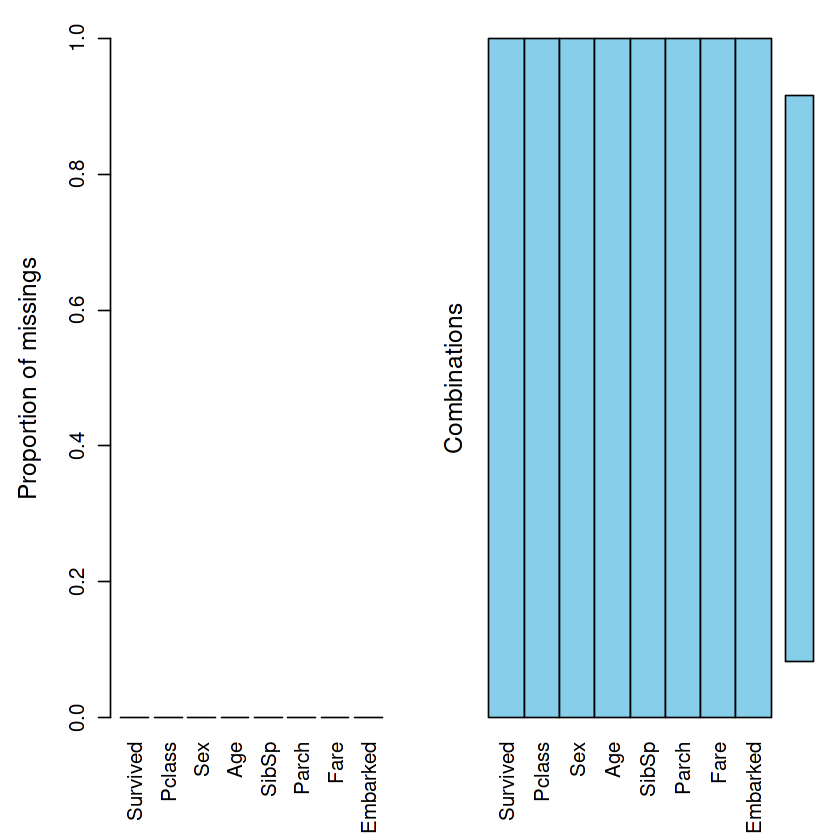

In [10]:
aggr(train_final)
# 결측치 처리 완료

In [11]:
glimpse(train_final)

Rows: 891
Columns: 8
$ Survived <fct> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0…
$ Pclass   <fct> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 2…
$ Sex      <fct> male, female, female, female, male, male, male, male, female,…
$ Age      <dbl> 22, 38, 26, 35, 35, 31, 54, 2, 27, 14, 4, 58, 20, 39, 14, 55,…
$ SibSp    <int> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 0, 4, 0, 1, 0, 0…
$ Parch    <int> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0…
$ Fare     <dbl> 7.2500, 71.2833, 7.9250, 53.1000, 8.0500, 8.4583, 51.8625, 21…
$ Embarked <fct> S, C, S, S, S, Q, S, S, S, C, S, S, S, S, S, S, Q, S, S, C, S…


# 1) Decision Tree
## **타이타닉 데이터로 보는 의사결정나무 모델**
* **rpart** Library 사용

In [12]:
library(rpart)
library(rpart.plot)

## **Training** with Decision Tree
* Decision Tree 모델 학습

In [13]:
# 종속변수: Survived
# 독립변수: Survived를 제외한 나머지
model_tree <- rpart(Survived ~ .,
                   data = train_final, method='class')

In [14]:
summary(model_tree)

Call:
rpart(formula = Survived ~ ., data = train_final, method = "class")
  n= 891 

          CP nsplit rel error    xerror       xstd
1 0.44444444      0 1.0000000 1.0000000 0.04244576
2 0.03070175      1 0.5555556 0.5555556 0.03574957
3 0.02631579      3 0.4941520 0.5350877 0.03525959
4 0.02046784      4 0.4678363 0.5292398 0.03511588
5 0.01461988      5 0.4473684 0.5087719 0.03459945
6 0.01000000      6 0.4327485 0.4941520 0.03421740

Variable importance
     Sex     Fare   Pclass      Age    SibSp    Parch Embarked 
      46       15       13       11        6        6        3 

Node number 1: 891 observations,    complexity param=0.4444444
  predicted class=0  expected loss=0.3838384  P(node) =1
    class counts:   549   342
   probabilities: 0.616 0.384 
  left son=2 (577 obs) right son=3 (314 obs)
  Primary splits:
      Sex      splits as  RL,           improve=124.42630, (0 missing)
      Pclass   splits as  RRL,          improve= 43.78183, (0 missing)
      Fare     < 10.48

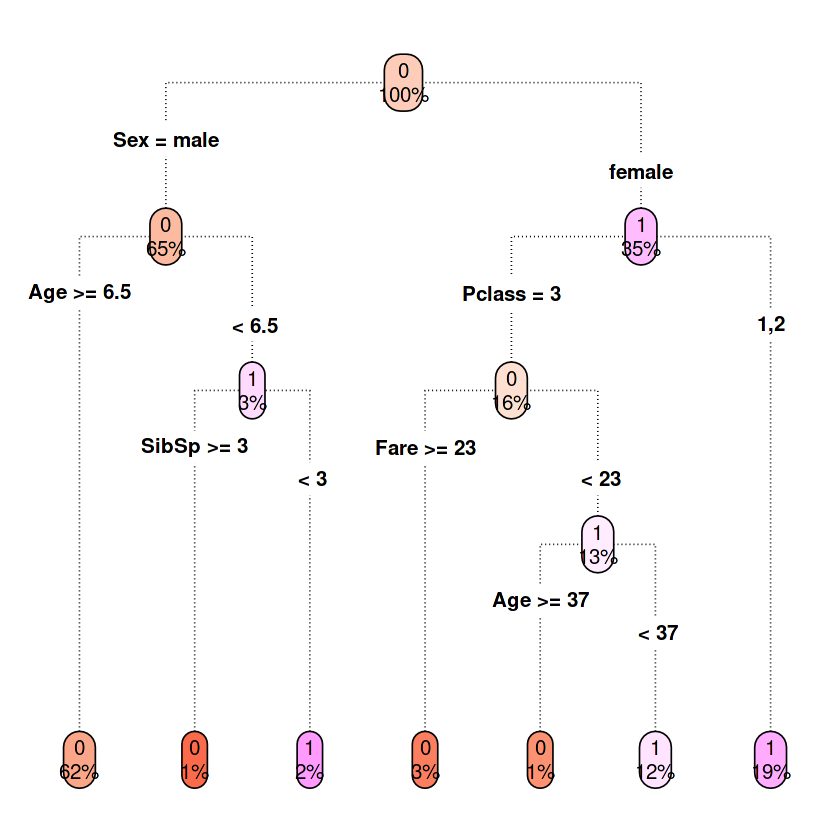

In [15]:
# 의사결정나무 시각화
rpart.plot(model_tree, type=4, branch.lty=3, extra=100, box.palette ="RdPu")

## **Prediction** with Decision Tree
* 학습시킨 Decision Tree 모델로 Survived(생존여부) 예측

In [16]:
# 랜덤으로 row 10개 선정 및 예측
set.seed(1234)
test_sample <- train_final %>% sample_n(10)
test_sample

Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
<fct>,<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>
1,3,male,19.00,0,0,8.0500,S
0,3,male,35.00,0,0,7.8958,C
0,3,female,28.00,0,0,7.8958,S
1,3,male,20.00,1,1,15.7417,C
1,3,female,0.75,2,1,19.2583,C
1,2,female,28.00,0,0,12.6500,S
1,1,male,23.00,0,1,63.3583,C
0,1,male,21.00,0,1,77.2875,S
0,3,male,20.00,0,0,8.6625,S


In [17]:
independent <- test_sample[c(-1)] # 종속변수 Survived 예측에 사용할 독립변수

print("확률 기반 예측, 0 -> Pred 'Dead', 1 -> Pred 'Survived'")
predict(model_tree, newdata = independent)

print("확률에 따른 생존여부 분류")
predict(model_tree, newdata = independent, type='class')

[1] "확률 기반 예측, 0 -> Pred 'Dead', 1 -> Pred 'Survived'"


,0,1
1,0.83333333,0.1666667
2,0.83333333,0.1666667
3,0.38181818,0.6181818
4,0.83333333,0.1666667
5,0.38181818,0.6181818
6,0.05294118,0.9470588
7,0.83333333,0.1666667
8,0.83333333,0.1666667
9,0.83333333,0.1666667
10,0.83333333,0.1666667


[1] "확률에 따른 생존여부 분류"


1  2  3  4  5  6  7  8  9 10 
 0  0  1  0  1  1  0  0  0  0 
Levels: 0 1

In [18]:
predict_by_tree <- predict(model_tree, newdata = independent, type='class')

# 원본 데이터의 생존여부 (정답)과 의사결정나무 모델을 통한 예측 결과를 대조
data.frame(reference = test_sample$Survived, 
           predict = predict_by_tree)

,reference,predict
,<fct>,<fct>
1,1,0
2,0,0
3,0,1
4,1,0
5,1,1
6,1,1
7,1,0
8,0,0
9,0,0


# 2) Random Forest
## **타이타닉 데이터로 보는 랜덤포레스트 모델**
* **랜덤포레스트**: Decision Tree (의사결정나무) 여러 개를 결합하여 성능을 향상하는 앙상블 기법이 적용된 모델
* **randomForest** Library 사용
### **랜덤포레스트 모델에 대한 정보**
* **Number of trees**: 학습에 이용된 결정트리의 개수
* **No. of variables tried at each split**: 각 분기점별로 랜덤으로 선택된 변수의 개수
* **OOB (Out Of Bag) estimate of error rate**: 오류율

    오류율 - 랜덤포레스트 모델 성능 평가의 지표, 
* **Confusion matrix**: 혼동행렬 (모델 정확도 평가 지표)
* **class.error**: 분류(class)별 오류율

In [19]:
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine




## **Training** with Random Forest
* Random Forest 모델 학습

In [20]:
model_rf <- randomForest(Survived ~ .,
                         data = train_final)

In [21]:
model_rf


Call:
 randomForest(formula = Survived ~ ., data = train_final) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 16.5%
Confusion matrix:
    0   1 class.error
0 499  50  0.09107468
1  97 245  0.28362573

## Random Forest Plot
* **결정트리 개수에 따른 랜덤 포레스트의 오류율** 차트 시각화
* x축: 결정트리 개수
* y축: 랜덤 포레스트 오류율
* Black Line: 평균 오류율 (OOB)
* Red Line: '사망' 클래스에 대한 오류율
* Green Line: '생존' 클래스에 대한 오류율
* 결정트리 개수가 많아질수록 오류율이 낮아지며, 100개를 넘어가며 오류율이 일정하게 수렴함

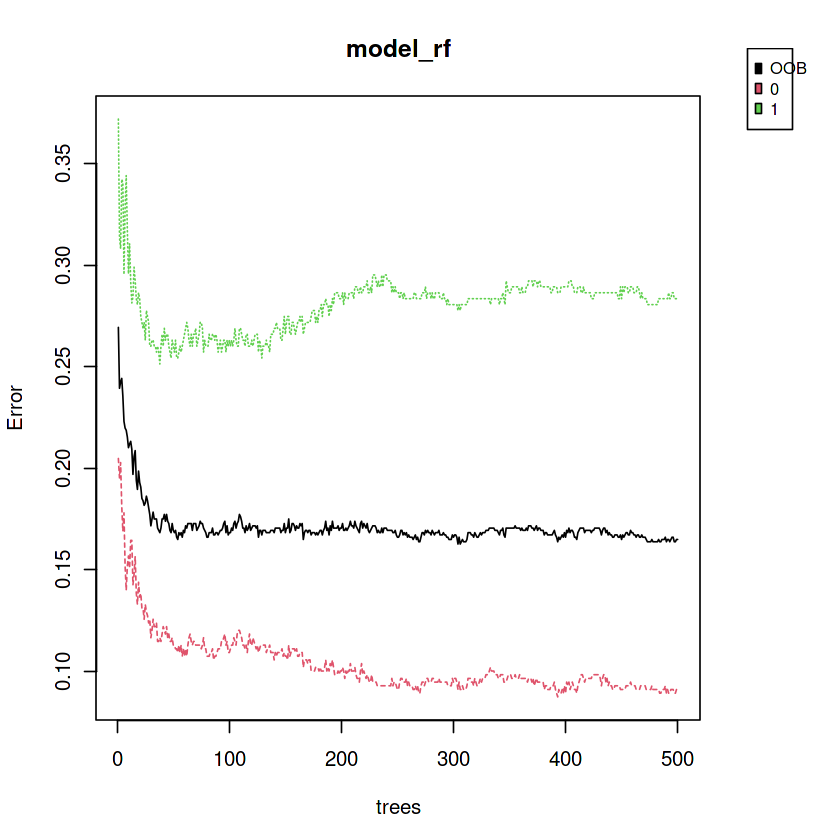

In [22]:
layout(matrix(c(1,2),nrow=1),width=c(5,1))

# 랜덤포레스트 모델 오류율 차트 시각화
par(mar=c(5,4,4,0))
plot(model_rf)

# 범례 표시
par(mar=c(2,0,2,0)) 
plot(c(0,1), type="n", axes = F, xlab="", ylab="")
legend("top", colnames(model_rf$err.rate),col=1:4,cex=0.8,fill=1:4)

## 설명변수별 중요도 확인
* 모델 학습에 이용된 설명변수별로 그 중요도를 확인

* 중요도는 각 변수가 얼마나 **'효율적인 분류'**를 수행하는가에 따라 결정됨

    효율적인 분류: Reducing, Lowering, Decreasing the Impurity Level (불순도의 감소)
    
    랜덤포레스트에서는 의사결정나무에서와 달리 모든 변수가 사용되므로, 변수 중요도 평가가 유용함

* **varUsed**: 각 설명변수가 랜덤포레스트 내 결정트리에 사용된 횟수를 보여줌

In [23]:
names(train_final)
varUsed(model_rf)

[1] "Survived" "Pclass"   "Sex"      "Age"      "SibSp"    "Parch"    "Fare"    
[8] "Embarked"

[1]  3171  2272 12950  5440  4449 12590  4080

* **MeanDecreaseGini (=Gini important score)**: 해당 설명변수(feature)가 모델에 적용되면서, 분류의 불순도(impurity)를 얼마나 감소시키는가에 대한 지표
    
    각 트리의 분기점에서, 분류기에서 쓰이는 설명변수들이 얼마나 **효율적으로 분류**하는가에 대한 평균값을 나타냄
* **varlmpPlot (variable important)**: 분류에 결정적인 기여를 하는 변수들의 순위를 시각화

In [24]:
model_rf$importance

,MeanDecreaseGini
Pclass,34.36502
Sex,101.50663
Age,59.78682
SibSp,16.07446
Parch,12.22787
Fare,65.43525
Embarked,11.72015


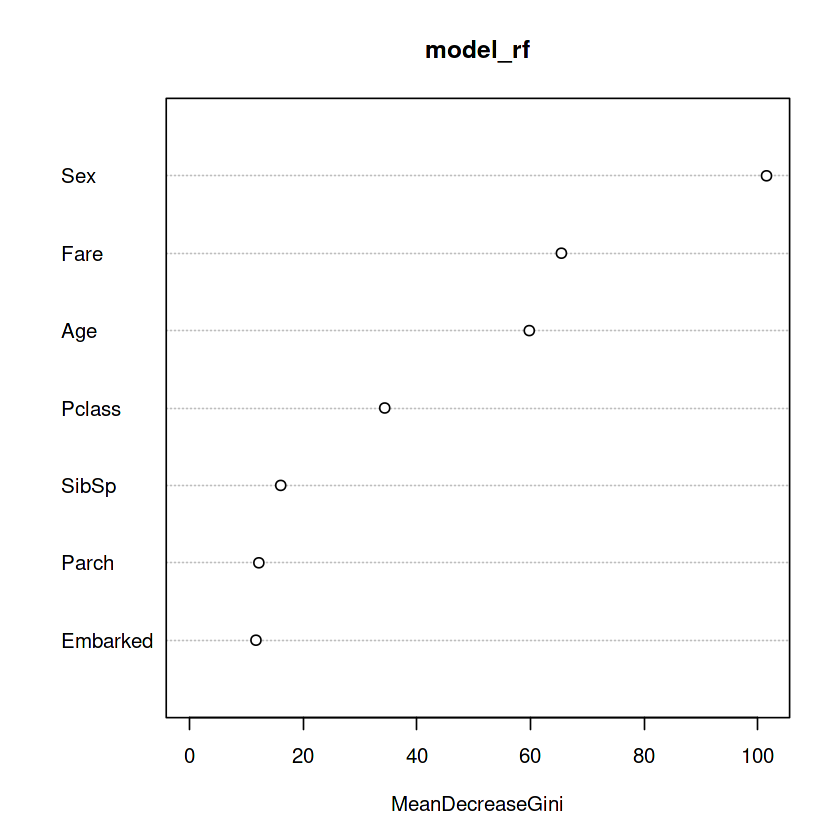

In [25]:
varImpPlot(model_rf)

* **treesize**: 결정트리별로 리프 노드(leaf node)의 개수를 출력

In [26]:
treesize(model_rf)

[1]  67  92  60  91  96  85  73 125  72  78 105  89 113  69  61 110  79  78
 [19]  85 103 105  87  89  72  79  82  91  95 125 107  96  84  84 100  87  66
 [37] 104 111 100  81  71  93 114  63 123 102 120 105 108  82  80  74  74 111
 [55]  80  91  94  77  81  79  89  74  72  61 101  82 121  88  69  84 114 104
 [73]  69 111  97  81  58  89 100  73  75 105  84  85  51 133  62  81  95  85
 [91]  73  85  76  87 104 103  76  92 112  60 105  71 104  50  68  86 107  68
[109]  82  70  93  97  88  61  86  75  75  82  92 116 114  80 118  86  97  68
[127] 108  88  96 105 114 120  95  74 109  62  61 112 113 101  71  95  79 104
[145]  94  69  72  95  58  90 106  82 104 100 101 113 104  91  99 101  56  95
[163]  85  82  97  57  94  80  97  83 112  98  79 107  93  66 101  78 100  94
[181]  78  72  90 106  92  99  73  99  84  75 120  91  78  90 105  74  90 110
[199] 107  98 101 103  79  93  95  74  66  96  96  92  96  77  72  64 116  81
[217]  96  73  90 108  70 118  93 107  86  92 106  69  74  55  94  59 103 126
[235]  91 101  92  98  75  96  63 124 109 103  88 109  98  58 102 114  62 101
[253] 103  87 115  82  98  92  72  80  94 103  74 124 118  91 118 113  84 100
[271] 102  74 104 116  98 117  87  70  76  73 122  92  73  73 102  88 108  79
[289]  99  78 103  84 144 116  86 102 144  96  84  86 124  90 144  83 120  81
[307]  78 105  96  75  72 107  54  61 102  86  90 108 117  82 110 102  70 102
[325]  89 122  90 110  92 110  88 121  76  83  77  98  75 106  96  91 106  72
[343]  64  71  81 102  56  90  82  93  70  92 103  65  58  76  93 111  94  87
[361]  82 119  98  86  68  91  84 105  88  97  85 115 107  86  39  71  97  66
[379] 115  97  79  93  79 124  91  73  77 103 112 113 112 111  77 114 115  60
[397]  68 130  73  67 105  67  96  88 108  80  83 121  67  68  94  84  91 100
[415] 114  89  90 121  81 115  66  98  74  99  85  85 120  80  83 104 122  93
[433]  69  70 123  80  95 102  70  71  75  84  82 108 105 101  86  83  85 114
[451]  93 103 109  96  64 106  85 104  85 108  83 101  87  71  84  91  88 105
[469]  99  95  76 123  97  60  64 100 112  92  93 110 108  89  75 105  72  67
[487]  79  96  53  97  98  73  90  99  59 112 112 111  88  98

## **Prediction** with Random Forest
* 학습시킨 Random Forest 모델로 Survived(생존여부) 예측

In [27]:
print("확률 기반 예측, 0 -> Pred 'Dead', 1 -> Pred 'Survived'")
predict(model_rf, newdata = independent, type='prob')

print("확률에 따른 생존여부 분류")
predict(model_rf, newdata = independent, type='class')

[1] "확률 기반 예측, 0 -> Pred 'Dead', 1 -> Pred 'Survived'"


,0,1
1,0.938,0.062
2,0.980,0.020
3,0.628,0.372
4,0.298,0.702
5,0.052,0.948
6,0.028,0.972
7,0.384,0.616
8,0.770,0.230
9,0.998,0.002
10,0.998,0.002


[1] "확률에 따른 생존여부 분류"


1  2  3  4  5  6  7  8  9 10 
 0  0  0  1  1  1  1  0  0  0 
Levels: 0 1

In [28]:
predict_by_rf <- predict(model_rf, newdata = independent, type='class')

# 원본 데이터의 생존여부 (정답)과 의사결정나무 모델을 통한 예측 결과를 대조
data.frame(reference = test_sample$Survived, 
           predict = predict_by_rf)

,reference,predict
,<fct>,<fct>
1,1,0
2,0,0
3,0,0
4,1,1
5,1,1
6,1,1
7,1,1
8,0,0
9,0,0


# 3) Naive Bayes Classifier
## **타이타닉 데이터로 보는 나이브베이즈 분류 모델**
* **나이브 베이즈 분류**: 특성 간의 '독립'을 가정하는 **베이즈 정리**를 적용한 확률 기반 분류기 모델
* **naivebayes** Library 사용

In [29]:
library(naivebayes)

naivebayes 0.9.7 loaded



## **Training** with Naive Bayes Classifier
* Naive Bayes 모델 학습

In [30]:
model_nb <- naive_bayes(Survived ~.,
                       data = train_final)
summary(model_nb)


================================== Naive Bayes ================================== 
 
- Call: naive_bayes.formula(formula = Survived ~ ., data = train_final) 
- Laplace: 0 
- Classes: 2 
- Samples: 891 
- Features: 7 
- Conditional distributions: 
    - Bernoulli: 1
    - Categorical: 2
    - Gaussian: 4
- Prior probabilities: 
    - 0: 0.6162
    - 1: 0.3838

--------------------------------------------------------------------------------- 


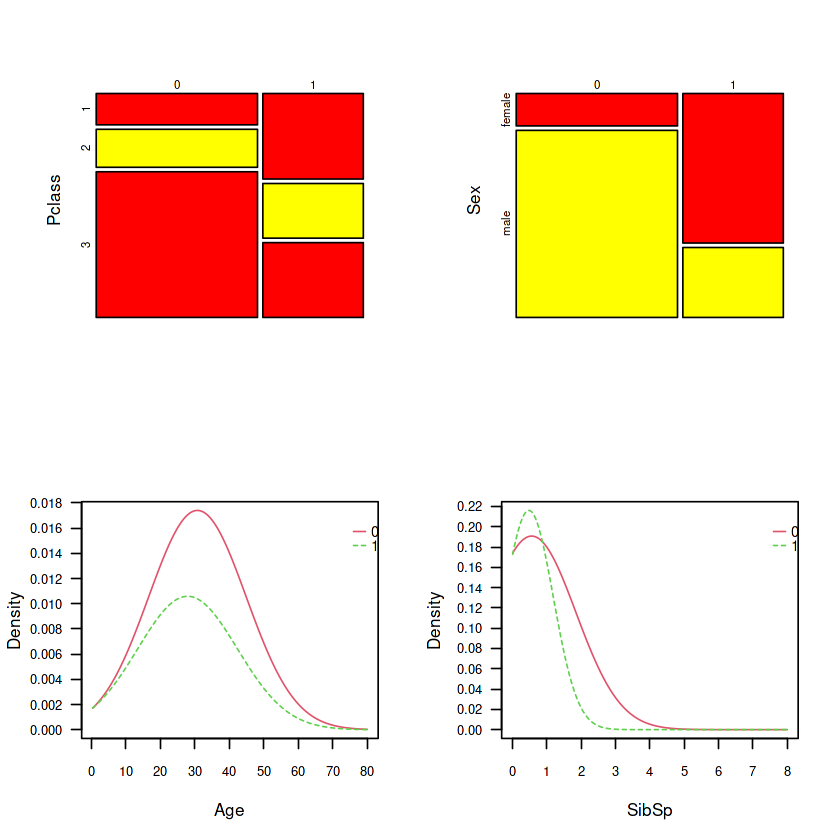

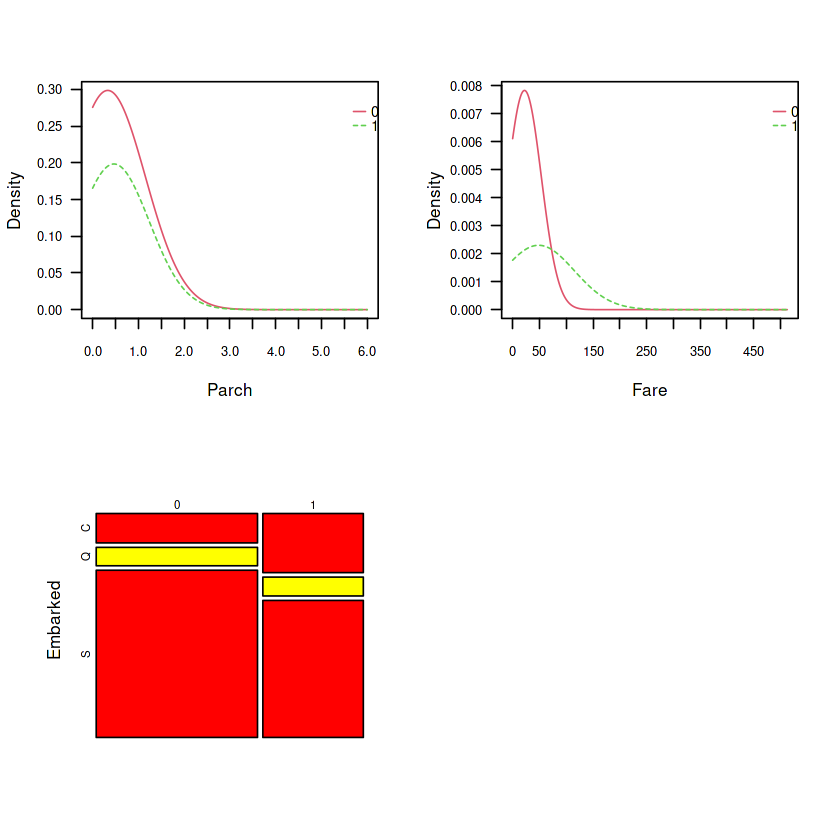

In [31]:
par(mfrow=c(2,2))
plot(model_nb)

## **Prediction** with Naive Bayes Classifier
* 학습시킨 Naive Bayes Classifier 모델로 Survived(생존여부) 예측

In [32]:
print("생존여부 분류")
predict(model_nb, newdata = independent, type='class')

[1] "생존여부 분류"


[1] 0 0 0 0 0 1 1 1 0 0
Levels: 0 1

In [33]:
predict_by_nb <- predict(model_nb, newdata = independent, type='class')

# 원본 데이터의 생존여부 (정답)과 의사결정나무 모델을 통한 예측 결과를 대조
data.frame(reference = test_sample$Survived, 
           predict = predict_by_nb)

reference,predict
<fct>,<fct>
1,0
0,0
0,0
1,0
1,0
1,1
1,1
0,1
0,0


# 4) Decision Tree vs. Random Forest vs. Naive Bayes Classifier
* 의사결정나무와 랜덤포레스트, 나이브베이즈 분류기 모델 성능 대조

In [34]:
data.frame(reference=test_sample$Survived, 
           DT = predict_by_tree,
           RF = predict_by_rf,
           NB = predict_by_nb)

,reference,DT,RF,NB
,<fct>,<fct>,<fct>,<fct>
1,1,0,0,0
2,0,0,0,0
3,0,1,0,0
4,1,0,1,0
5,1,1,1,0
6,1,1,1,1
7,1,0,1,1
8,0,0,0,1
9,0,0,0,0


In [35]:
# row 100개를 추출해 Decision Tree와 Random Forest 정확도 비교
test <- train_final %>% sample_n(100)

independent2 <- test[c(-1)]
predict_by_tree2 <- predict(model_tree, newdata = independent2, type='class')
predict_by_rf2 <- predict(model_rf, newdata = independent2, type='class')
predict_by_nb2 <- predict(model_nb, newdata = independent2, type='class')

In [36]:
test_df <- data.frame(reference = test$Survived,
                      DT = predict_by_tree2,
                      RF = predict_by_rf2,
                      NB = predict_by_nb2)

# 정답값과 일치여부를 DT_score, RF_score 칼럼을 생성해 확인
test_score <- test_df %>% mutate(DT_score = ifelse(reference == DT, 1, 0),
                                 RF_score = ifelse(reference == RF, 1, 0),
                                 NB_score = ifelse(reference == NB, 1, 0))

head(test_score, 10)

,reference,DT,RF,NB,DT_score,RF_score,NB_score
,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,1,0,0,0,0,0,0
2,1,1,1,0,1,1,0
3,1,0,1,0,0,1,0
4,1,1,1,1,1,1,1
5,0,1,0,1,0,1,0
6,0,0,0,0,1,1,1
7,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1


* **Accuracy** (정확도) 지표 확인

In [37]:
apply(test_score[c(5:7)], 2, sum)

DT_score RF_score NB_score 
      77       90       79

# 5) ROC Curves
### ROC (Receiver Operating Characteristic) Curve
* ROC Curve는 모델 성능 평가 지표 중 하나!

### ROC Curve 구하는 법
* **Confusion Matrix (혼동행렬)**: 실제 정답과 분류 결과 간의 관계를 나타낸 표

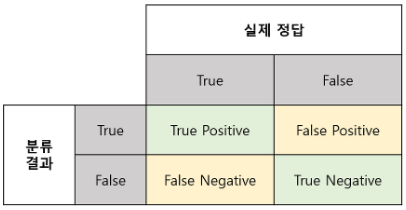

* **Recall (재현율)**: *실제로 True*인 것 중, 모델이 *True*라고 분류한 비율

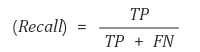

* **Fall-out (FRR, False Positive Rate)**: 실제 *False*인 것 중, 모델이 *True라고 분류*한 것의 비율

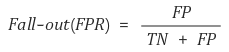


* **ROC Curve**는 **Fall-out에 따른 Recall의 변화**를 시각화한 것

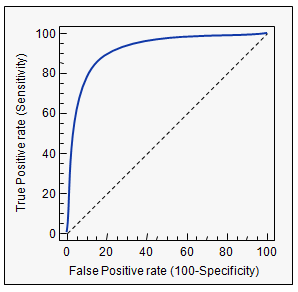

* Curve가 왼쪽 위 모서리에 가까워, **Recall이 크고, Fall-out이 작은** 모형이 **예측률이 좋은 모형**!
* **pROC** Library 사용

In [38]:
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following object is masked from ‘package:colorspace’:

    coords


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [39]:
predict_by_tree3 <- predict(model_tree, newdata = independent2, type='prob')
predict_by_rf3 <- predict(model_rf, newdata = independent2, type='prob')
predict_by_nb3 <- predict(model_nb, newdata = independent2, type='prob')

In [40]:
ROC_tree <- roc(test_score$reference, predict_by_tree3[,2])
ROC_rf <- roc(test_score$reference, predict_by_rf3[,2])
ROC_nb <- roc(test_score$reference, predict_by_nb3[,2])

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



### Plot **ROC Curves**

[1] "Accuracy % of Decision Tree:  0.77"

[1] "Accuracy % of Random Forest:  0.9"

[1] "Accuracy % of Naive Bayes:  0.79"

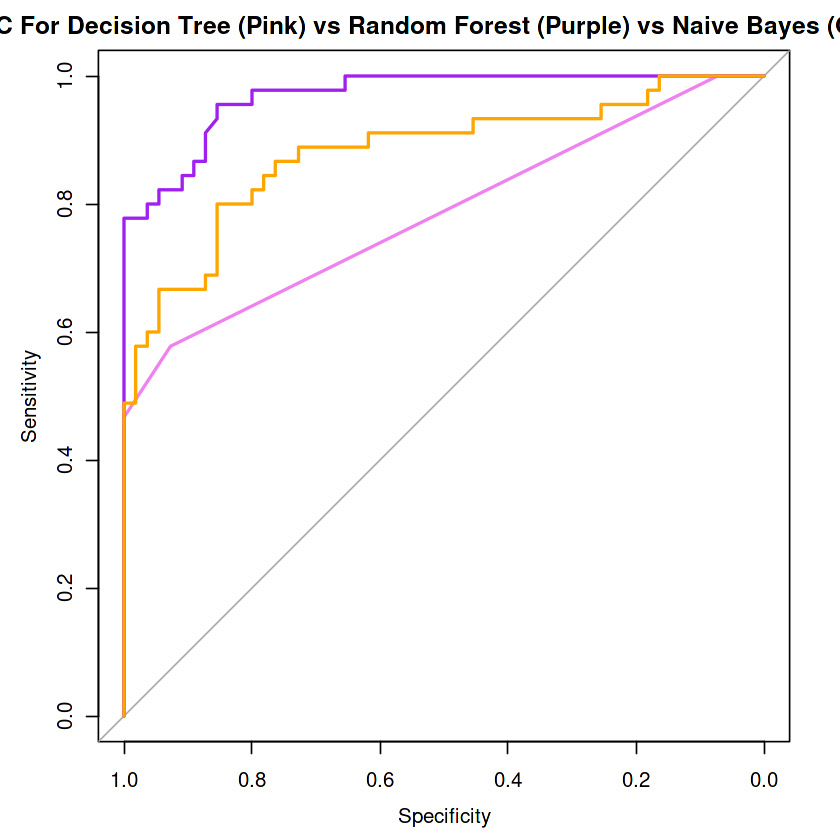

In [41]:
plot(ROC_tree, col='violet', main = "ROC For Decision Tree (Pink) vs Random Forest (Purple) vs Naive Bayes (Orange)")
lines(ROC_rf, col = 'Purple')
lines(ROC_nb, col = 'orange')

paste("Accuracy % of Decision Tree: ", mean(test_score$reference == round(predict_by_tree3[,2], digits = 0)))
paste("Accuracy % of Random Forest: ", mean(test_score$reference == round(predict_by_rf3[,2], digits = 0)))
paste("Accuracy % of Naive Bayes: ", mean(test_score$reference == round(predict_by_nb3[,2], digits = 0)))

## **AUC** - ROC Curve 면적 계산
* **AUC(Area Under Curve)**: 최댓값 = 1, 좋은 모델일수록 1에 가까운 값이 도출

In [42]:
ROC_dt_auc <- auc(ROC_tree)
ROC_rf_auc <- auc(ROC_rf)
ROC_nb_auc <- auc(ROC_nb)

In [43]:
paste("Area under curve of Decision Tree: ", round(ROC_dt_auc, 2))
paste("Area under curve of Random Forest: ", round(ROC_rf_auc, 2))
paste("Area under curve of Naive Bayes: ", round(ROC_nb_auc, 2))

[1] "Area under curve of Decision Tree:  0.78"

[1] "Area under curve of Random Forest:  0.97"

[1] "Area under curve of Naive Bayes:  0.88"

# 6) K-Nearest Neighbors
## **타이타닉 데이터로 보는 K 최근접 이웃 모델**
* **K-NN Algorithm**: 특정 값으로부터 가까운 거리에 위치한 **'K개'**의 값을 참조해 분류를 진행하는 모델
* **class** Library 사용


In [44]:
library(class)

## **Normalization (정규화) 진행**
* K-NN 알고리즘에서는 분류 과정에서 모든 특성의 scale을 고르게 반영하기 위해, **정규화 (Normalization)**가 필요함
* **Min-Max Normalization**: 최솟값을 0, 최댓값을 1로 고정한 뒤, 모든 값들을 0과 1사이의 값을 변환하는 방법
    
  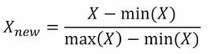

In [45]:
nor <- function(x) { (x - min(x)) / (max(x) - min(x)) }

* 종속변수 Survived와 명목형 변수 Sex, Embarked를 제외한, **범주형 독립 변수들만** normailization 진행

In [46]:
train_nor <- train_final %>% mutate(Age=nor(Age),
                                   SibSp=nor(SibSp),
                                   Parch=nor(Parch),
                                   Fare=nor(Fare)) %>%
                            select(-c(Survived, Sex, Embarked))

head(train_nor)

,Pclass,Age,SibSp,Parch,Fare
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,0.2711737,0.125,0,0.01415106
2,1,0.4722292,0.125,0,0.13913574
3,3,0.3214375,0.000,0,0.01546857
4,1,0.4345313,0.125,0,0.10364430
5,3,0.4345313,0.000,0,0.01571255
6,3,0.3842674,0.000,0,0.01650950


In [47]:
# 범주형 변수들의 scale이 0에서 1사이로 정규화된 것을 확인할 수 있음
summary(train_nor)

 Pclass       Age             SibSp             Parch             Fare        
 1:216   Min.   :0.0000   Min.   :0.00000   Min.   :0.0000   Min.   :0.00000  
 2:184   1st Qu.:0.2586   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.:0.01544  
 3:491   Median :0.3466   Median :0.00000   Median :0.0000   Median :0.02821  
         Mean   :0.3679   Mean   :0.06538   Mean   :0.0636   Mean   :0.06286  
         3rd Qu.:0.4722   3rd Qu.:0.12500   3rd Qu.:0.0000   3rd Qu.:0.06051  
         Max.   :1.0000   Max.   :1.00000   Max.   :1.0000   Max.   :1.00000  

In [48]:
test_nor <- test %>% mutate(Age=nor(Age),
                            SibSp=nor(SibSp),
                           Parch=nor(Parch),
                           Fare=nor(Fare)) %>% 
                        select(-c(Survived, Sex, Embarked))

head(test_nor)

,Pclass,Age,SibSp,Parch,Fare
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,0.6407014,0.000,0.00,0.007942883
2,3,0.4969819,0.125,0.25,0.031943668
3,1,0.5975855,0.000,0.00,0.043821106
4,1,0.2526588,0.250,0.50,0.508270730
5,3,0.2023570,0.125,0.00,0.020541721
6,2,0.2526588,0.000,0.00,0.017680906


## **Training** with K-Nearest Neighbors
* KNN 모델 학습
* **cl (classification)**: train dataset의 Survive (생존여부) 칼럼을 참조해 KNN 분류 모델 학습
* **k 값** 지정: 특정 값 **인근에 위치한 k개 데이터**의 정보를 바탕으로 해당 값을 분류함

In [49]:
model_KNN <- knn(train_nor, test_nor, cl=train_final$Survived, k=13)

## **Prediction** with K-Nearest Neighbors
* 학습시킨 KNN 모델로 Survived(생존여부) 예측

In [50]:
# Confusion Matrix
table_knn <- table(model_KNN, test$Survived)
table_knn

         
model_KNN  0  1
        0 45 20
        1 10 25

* **예측 정확도** 지표 확인
* 위 혼동행렬의 **대각행렬** -> **예측이 일치**한 결과 개수

In [51]:
accuracy_knn <- function(x){sum(diag(x) / (sum(rowSums(x)))) * 100}
accuracy_knn(table_knn)

[1] 70